In [970]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from category_encoders import TargetEncoder, LeaveOneOutEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV

Reading the housing data

In [971]:
housing_df = pd.read_csv('housedata/data.csv')

In [972]:
housing_df.shape

(4600, 18)

Dropping the date field as we were asked to ignore it for the hw

In [973]:
housing_df = housing_df.drop(['date'], axis=1)

### 2.1

Checking column data types

In [974]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4600 non-null   float64
 1   bedrooms       4600 non-null   float64
 2   bathrooms      4600 non-null   float64
 3   sqft_living    4600 non-null   int64  
 4   sqft_lot       4600 non-null   int64  
 5   floors         4600 non-null   float64
 6   waterfront     4600 non-null   int64  
 7   view           4600 non-null   int64  
 8   condition      4600 non-null   int64  
 9   sqft_above     4600 non-null   int64  
 10  sqft_basement  4600 non-null   int64  
 11  yr_built       4600 non-null   int64  
 12  yr_renovated   4600 non-null   int64  
 13  street         4600 non-null   object 
 14  city           4600 non-null   object 
 15  statezip       4600 non-null   object 
 16  country        4600 non-null   object 
dtypes: float64(4), int64(9), object(4)
memory usage: 611

Checking number of unique values in each column

In [975]:
housing_df.nunique()

price            1741
bedrooms           10
bathrooms          26
sqft_living       566
sqft_lot         3113
floors              6
waterfront          2
view                5
condition           5
sqft_above        511
sqft_basement     207
yr_built          115
yr_renovated       60
street           4525
city               44
statezip           77
country             1
dtype: int64

In [976]:
for col in ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition']:
    print(f"Column: {col} \nUnique Values:{sorted(housing_df[col].unique())}")

Column: bedrooms 
Unique Values:[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
Column: bathrooms 
Unique Values:[0.0, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.25, 6.5, 6.75, 8.0]
Column: floors 
Unique Values:[1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
Column: waterfront 
Unique Values:[0, 1]
Column: view 
Unique Values:[0, 1, 2, 3, 4]
Column: condition 
Unique Values:[1, 2, 3, 4, 5]


We can decide whether to treat variables as continuous or categorical based on the field names, the data types, the number of unique values and the list of unique values.   
* We can treat the **street, city, statezip and country** as categorical variables as they are clearly categorical variables with no inherent ordering   
* Waterfront is a binary variable (and hence a categorical variable)   
* The variables view and condition may have some meaning to their ordering and hence it may be alright to treat them as continuous but without having this information, it is better to treat them as categorical as well.   
* The variables floors, bathroom and bedrooms are discrete variables. They can be treated either as categorical variables or continuous variables since they have an inherent ordering. Here, since bedrooms and bathrooms have a decent number of unique values, we can treat them as continuous. The advantage of treating them as continuous is the ease of handling new values for these fields in the future. Based on model performance and relationships with the price we can choose to convert them to categorical if necessary. 
* Floors can be treated as a categorical variable due to the smaller number of unique values

However, since street has 4476 unique values in a dataset of 4600 samples, there isn't much that can be learned from this field. Country has only one value (USA) and hence is not useful as well. So we can drop these two fields from the data

In [977]:
housing_df = housing_df.drop(['street', 'country'], axis=1)

In [978]:
housing_df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'city', 'statezip'],
      dtype='object')

In [979]:
continuous = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
categorical = ['floors', 'waterfront', 'view', 'condition', 'city', 'statezip']
target = ['price']

Checking the data distribution for the target variable price

In [980]:
housing_df['price'].describe()

count    4.600000e+03
mean     5.519630e+05
std      5.638347e+05
min      0.000000e+00
25%      3.228750e+05
50%      4.609435e+05
75%      6.549625e+05
max      2.659000e+07
Name: price, dtype: float64

We notice that there are some 0 values. The price (value) of a house cannot be 0 unless it is a gift. Even so, such data points do not help with the modeling process given our goal and hence we can remove such data points

In [981]:
print(f"Number of rows with a housing price of zero: {len(housing_df[housing_df['price']==0])}")

Number of rows with a housing price of zero: 49


In [982]:
housing_df = housing_df[housing_df['price']!=0]

### 2.2

Let's look at the histogram of all the continuous variables to check if any of them require any special treatment

In [983]:
housing_plot = pd.melt(housing_df[continuous].reset_index(), id_vars='index')

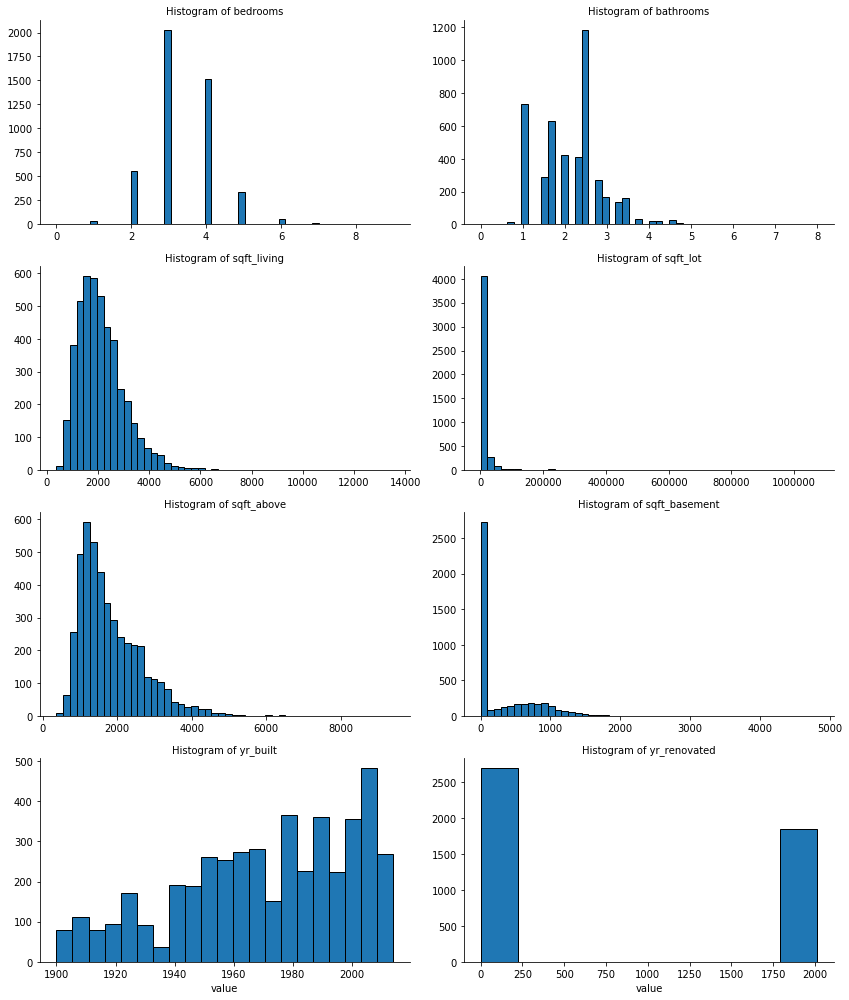

In [984]:
fg = sns.FacetGrid(data=housing_plot, col='variable', col_wrap=2, sharex=False, sharey=False, height=3.5, aspect=1.7)
fg = fg.map(sns.distplot, 'value', kde=False, hist_kws={'edgecolor':'k','alpha':1})
fg.set_titles(col_template = 'Histogram of {col_name}')
plt.show()

In [985]:
housing_df[continuous].describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated
count,4551.000000,4551.000000,4551.000000,4.551000e+03,4551.000000,4551.000000,4551.000000,4551.000000
mean,3.394639,2.155021,2132.372226,1.483528e+04,1822.221710,310.150516,1970.795649,808.564052
std,0.904595,0.776351,955.949708,3.596408e+04,854.452888,461.987629,29.760073,979.421487
min,0.000000,0.000000,370.000000,6.380000e+02,370.000000,0.000000,1900.000000,0.000000
25%,3.000000,1.750000,1460.000000,5.000000e+03,1190.000000,0.000000,1951.000000,0.000000
50%,3.000000,2.250000,1970.000000,7.680000e+03,1590.000000,0.000000,1976.000000,0.000000
75%,4.000000,2.500000,2610.000000,1.097800e+04,2300.000000,600.000000,1997.000000,1999.000000
max,9.000000,8.000000,13540.000000,1.074218e+06,9410.000000,4820.000000,2014.000000,2014.000000


Based on the histograms and the stats above, we notice that more than half the values for sqft_basement and yr_renovated are 0. This could mean that the house does not have a basement or it could be a missing value. Similarly it could mean that the house was not renovated or it could be a missing value. We will try both approaches to see what performs better on the cross validation

Plotting a histogram of price

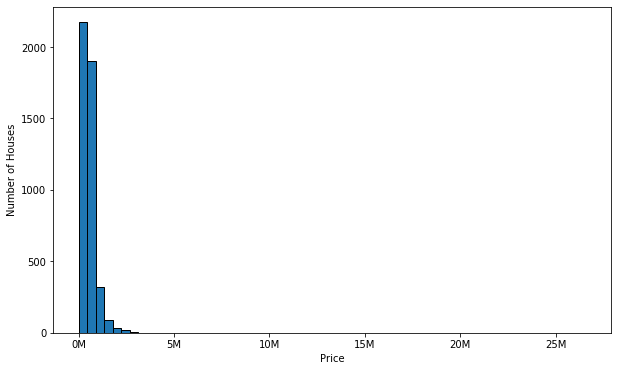

In [986]:
plt.figure(figsize=(10,6))
ax = sns.distplot(housing_df['price'], kde=False, bins=60, hist_kws={'edgecolor':'k','alpha':1})
ax.xaxis.set_major_formatter(FuncFormatter(lambda x,pos: '%1.0fM' % (x*1e-6)))
ax.xaxis.set_major_locator(MultipleLocator(5000000))
ax.set_xlabel('Price')
ax.set_ylabel('Number of Houses')
plt.show()

It's clear from the above histogram that there are some outliers in the data. Let's look at some percentile values

In [987]:
percentiles = pd.DataFrame(housing_df['price'].quantile(np.around(np.arange(0.9,1.01,0.01),2))).T.reset_index(drop=True)

In [988]:
percentiles

,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.00
0,905000.0,946250.0,975000.0,1031944.0,1100000.0,1187500.5,1275000.0,1391500.0,1635000.0,2016000.0,26590000.0


We may want to treat the outliers. Removing data points that have a price above $2.5M

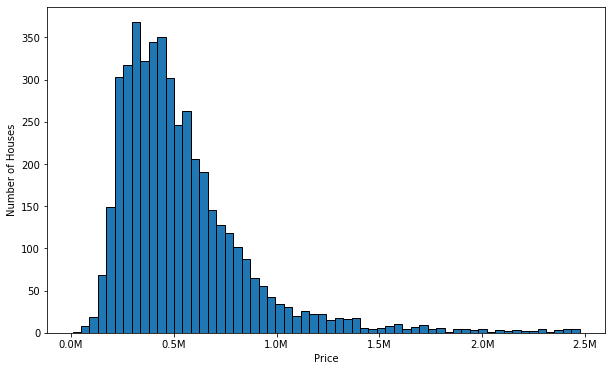

In [989]:
plt.figure(figsize=(10,6))
ax = sns.distplot(housing_df[housing_df['price']<2500000]['price'], kde=False, bins=60, hist_kws={'edgecolor':'k','alpha':1})
ax.xaxis.set_major_formatter(FuncFormatter(lambda x,pos: '%1.1fM' % (x*1e-6)))
ax.xaxis.set_major_locator(MultipleLocator(500000))
ax.set_xlabel('Price')
ax.set_ylabel('Number of Houses')
plt.show()

Our histogram looks much better now (even though the price still has a right skew). We can remove these outliers

In [990]:
housing_df = housing_df[housing_df['price']<2500000]

### 2.3

Plotting a scatter plot between the continuous variables and price to observe relationships

In [991]:
housing_target_plot = pd.melt(housing_df[continuous + ['price']].reset_index(), id_vars=['index', 'price'])

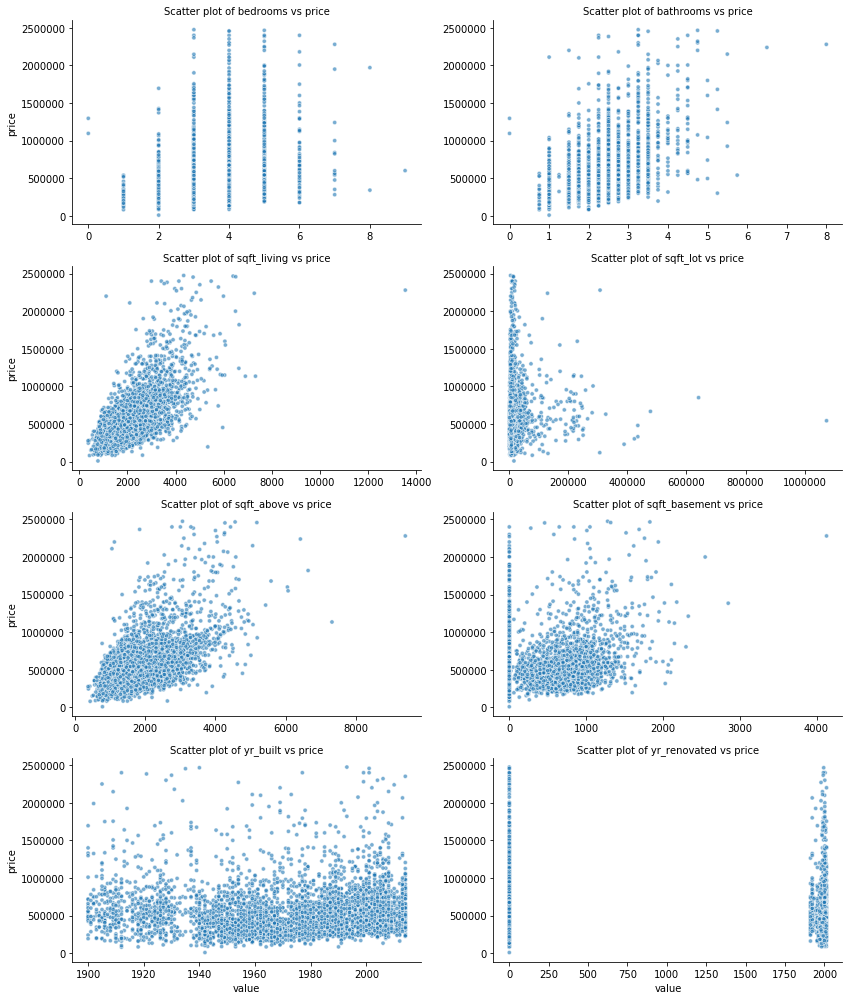

In [992]:
fg = sns.FacetGrid(data=housing_target_plot, col='variable', col_wrap=2, sharex=False, sharey=False, height=3.5, aspect=1.7)
fg = fg.map(sns.scatterplot, 'value', 'price', size=5, alpha=0.6)
fg.set_titles(col_template = 'Scatter plot of {col_name} vs price')
plt.show()

### 2.4

Splitting the data into training and test using the default ratios of 75 to 25

In [1011]:
X_train, X_test, y_train, y_test = train_test_split(housing_df.drop('price', axis=1), housing_df['price'], random_state=1)

In [1012]:
zero_median_imp = SimpleImputer(missing_values=0, strategy='median')
onehot = OneHotEncoder(handle_unknown='ignore')
le = LeaveOneOutEncoder()
stdscaler = StandardScaler()

In [1013]:
cat_onehot = categorical.copy()
cat_onehot.remove('statezip')

In [1014]:
ct_imp = make_column_transformer((zero_median_imp, continuous),
                        (onehot, cat_onehot),
                        (le, ['statezip']),
                  remainder='passthrough')

In [1015]:
impute_scale_pipe = make_pipeline(zero_median_imp, stdscaler)

In [1016]:
ct_imp_scale = make_column_transformer((impute_scale_pipe, continuous),
                        (onehot, cat_onehot),
                        (le, ['statezip']),
                  remainder='passthrough')

In [1017]:
ct_noimp_scale = make_column_transformer((stdscaler, continuous),
                                   (onehot, cat_onehot),
                        (le, ['statezip']),
                  remainder='passthrough')

Evaluating Linear Regression, Ridge, Lasso and ElasticNet using the different column transfomers but with default hyperparameters (alpha and l1ratio as applicable)

In [1055]:
model_pipe = Pipeline([('scaler', StandardScaler()),
                      ('regressor', LinearRegression())])

param_grid = {'scaler': [ct_imp, ct_imp_scale, ct_noimp_scale],
              'regressor': [LinearRegression(), Ridge(), 
                            Lasso(tol=0.01, max_iter=10000), 
                            ElasticNet(tol=0.01, max_iter=10000)]
             }

grid = GridSearchCV(model_pipe, param_grid, n_jobs=-1)

In [1056]:
gr = grid.fit(X_train, y_train)

In [1057]:
print(f"The best score obtained on the validation was {grid.best_score_:0.3f}")

The best score obtained on the validation was 0.752


In [1021]:
cv_results = pd.DataFrame(grid.cv_results_)

In [1022]:
cv_results['regression_model'] = cv_results['param_regressor'].apply(lambda x:x.__class__.__name__)

Printing out the top model for each algorithm

In [1023]:
cv_results.sort_values(['regression_model', 'rank_test_score']).drop_duplicates(subset=['regression_model'], keep='first').reset_index(drop=True)[['regression_model', 'rank_test_score', 'mean_test_score']]

,regression_model,rank_test_score,mean_test_score
0,ElasticNet,7,0.721052
1,Lasso,2,0.751513
2,LinearRegression,1,0.752283
3,Ridge,10,0.677433


We can see that LinearRegression had the best score when we use the default parameter values. Let's look at the preprocessing parameters for the best model

In [1024]:
grid.best_params_

{'regressor': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'scaler': ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                   transformer_weights=None,
                   transformers=[('standardscaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True),
                                  ['bedrooms', 'bathrooms', 'sqft_living',
                                   'sqft_lot', 'sqft_above', 'sqft_basement',
                                   'yr_built', 'yr_renovated']),
                                 ('onehotencoder',
                                  OneHotEncoder(categories='auto', drop=None,
                                                dtype=<class 'numpy.float64'>,
                                                handle_unknown='ignore',
                                                sparse=True),
                 

The best gridsearched model seems to be a Linear Regression Model with the preprocessing steps that include the standardscaler for the continuous variables and the one hot encoder for the continuous variables (other than the zip code) and the leave one out encoder for the zip. We will use this columntransformer for the following grid search used for hyperparameter tuning

Also, it can be seen from the best model that the StandardScaler helps improve the score on the validation set since the column transformer with the standard scaler performed better than the column transformer without it

In [1025]:
pipe_hyp = Pipeline([('scaler', StandardScaler()),
                 ('regressor', Ridge())])

In [1026]:
param_grid_hyp = [{'scaler':[ct_noimp_scale],
               'regressor':[Ridge()],
              'regressor__alpha':np.logspace(-3,3,13)},
              {'scaler':[ct_noimp_scale],
               'regressor':[Lasso(tol=0.01, max_iter=10000)],
              'regressor__alpha':np.logspace(-3,3,13)},
              {'scaler':[ct_noimp_scale],
              'regressor':[ElasticNet(tol=0.1, max_iter=10000)],
               'regressor__alpha':np.logspace(-3,3,13),
              'regressor__l1_ratio':np.linspace(0,1,11)}
              ]

In [1027]:
grid_hyp = GridSearchCV(pipe_hyp, param_grid_hyp, n_jobs=-1)

In [1028]:
gr_hyp = grid_hyp.fit(X_train, y_train)

/Users/harish/anaconda3/envs/applied_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11802110250989.184, tolerance: 2790944275246.8574
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/harish/anaconda3/envs/applied_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12356474641228.621, tolerance: 2780212168777.6396
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/harish/anaconda3/envs/applied_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9509955593854.117, tolerance: 2759229462093.8833
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/h

/Users/harish/anaconda3/envs/applied_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31720905873637.836, tolerance: 27909442752468.574
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/harish/anaconda3/envs/applied_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34133156879405.31, tolerance: 27802121687776.4
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/harish/anaconda3/envs/applied_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34166748949819.043, tolerance: 27592294620938.832
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/har

/Users/harish/anaconda3/envs/applied_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32271597215944.445, tolerance: 27909442752468.574
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/harish/anaconda3/envs/applied_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34681736425399.383, tolerance: 27802121687776.4
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/harish/anaconda3/envs/applied_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34599498920549.348, tolerance: 27592294620938.832
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/ha

/Users/harish/anaconda3/envs/applied_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43667643392779.84, tolerance: 27909442752468.574
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/harish/anaconda3/envs/applied_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46823808673999.41, tolerance: 27802121687776.4
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/harish/anaconda3/envs/applied_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44846129667087.14, tolerance: 27592294620938.832
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/haris

/Users/harish/anaconda3/envs/applied_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76727467106100.88, tolerance: 27909442752468.574
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/harish/anaconda3/envs/applied_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80440418241593.73, tolerance: 27802121687776.4
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/harish/anaconda3/envs/applied_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:457: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78095270071860.27, tolerance: 27592294620938.832
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/haris

In [1029]:
print(f"The best score obtained on the validation was {grid_hyp.best_score_:0.3f}")

The best score obtained on the validation was 0.754


In [1030]:
grid_hyp.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('standardscaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'sqft_above',
                                                   'sqft_basement', 'yr_built',
                                                   'yr_renovated']),
                                                 ('onehotencoder',
                   

In [1031]:
cv_results_hyp = pd.DataFrame(grid_hyp.cv_results_)

In [1032]:
cv_results_hyp['regression_model'] = cv_results_hyp['param_regressor'].apply(lambda x:x.__class__.__name__)

Visualizing the effect of alpha on the validation performance for Ridge and Lasso

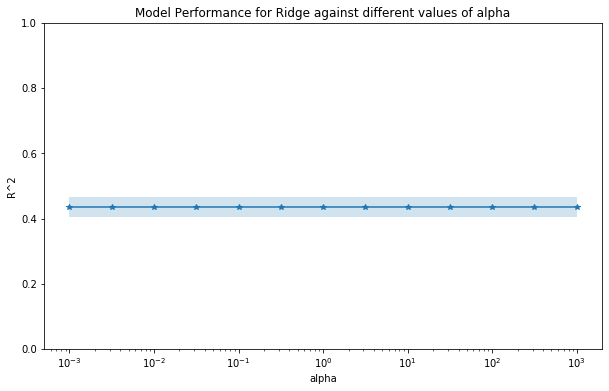

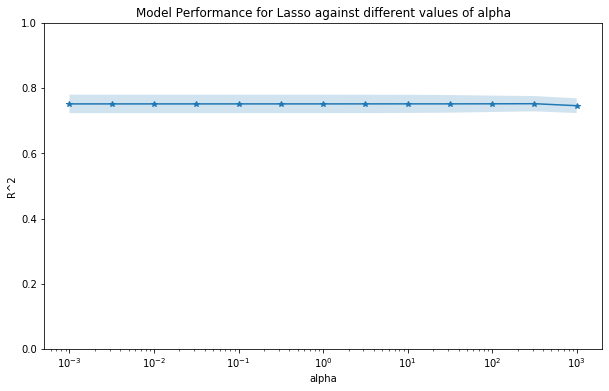

In [1033]:
for model in ['Ridge', 'Lasso']:
    cv_results_model = cv_results_hyp[cv_results_hyp['regression_model']==model]
    plt.figure(figsize=(10,6))
    plt.plot(cv_results_model['param_regressor__alpha'], cv_results_model['mean_test_score'], marker='*')
    plt.fill_between(cv_results_model.param_regressor__alpha.astype(np.float),
                 cv_results_model['mean_test_score'] + cv_results_model['std_test_score'],
                 cv_results_model['mean_test_score'] - cv_results_model['std_test_score'], alpha=0.2)
    plt.ylim(ymin=0, ymax=1)
    plt.title(f'Model Performance for {model} against different values of alpha')
    plt.xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('R^2')
    plt.show()

We notice that the alpha value does not change the performance considerably for Ridge and Lasso

In [1034]:
elasticnet = cv_results_hyp[cv_results_hyp['regression_model']=='ElasticNet'].copy()

In [1035]:
elasticnet['param_regressor__alpha'] = elasticnet['param_regressor__alpha'].apply(lambda x:round(x,4))
elasticnet['param_regressor__l1_ratio'] = elasticnet['param_regressor__l1_ratio'].apply(lambda x:round(x,1))

In [1036]:
elasticnet = pd.pivot(elasticnet, index='param_regressor__alpha', columns='param_regressor__l1_ratio', values='mean_test_score')

Heatmap of performance at different values of alpha and l1ratio for the elasticnet

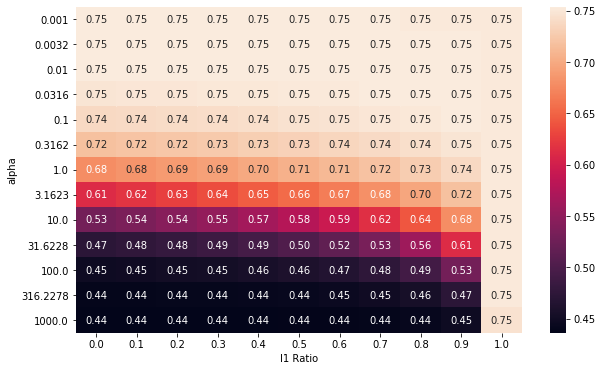

In [1037]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(elasticnet, annot=True, fmt='.2f')
ax.set_xlabel('l1 Ratio')
ax.set_ylabel('alpha')
plt.show()

For Elastic Net however, unlike Ridge and Lasso, we do notice a significant impact of hyperparameter tuning on model performance. An l1ratio of 1 (which is indicative of a Lasso model) performs the best along with lower values of alpha

**Best Model Performance on the Test Set**

In [1038]:
print(f"Score of the best model on the test set is {grid_hyp.best_estimator_.score(X_test, y_test):0.3f}")

Score of the best model on the test set is 0.773


Printing out the top model for each algorithm

In [1039]:
cv_results_hyp.sort_values(['regression_model', 'rank_test_score']).drop_duplicates(subset=['regression_model'], keep='first').reset_index(drop=True)[['regression_model', 'rank_test_score', 'mean_test_score']]

,regression_model,rank_test_score,mean_test_score
0,ElasticNet,1,0.753894
1,Lasso,36,0.752066
2,Ridge,157,0.434969


### 2.6

Using the best hyperparameter settings for each algorithm from above to refit the pipelines and obtain the coefficients

In [1040]:
elasticnet_pipe = make_pipeline(ct_noimp_scale, ElasticNet(alpha=0.01, l1_ratio=0.5, tol=0.1, max_iter=10000))

In [1041]:
el = elasticnet_pipe.fit(X_train, y_train)

In [1042]:
ridge_pipe = make_pipeline(ct_noimp_scale, Ridge(alpha=1000))

In [1043]:
ri = ridge_pipe.fit(X_train, y_train)

In [1044]:
lasso_pipe = make_pipeline(ct_noimp_scale, Lasso(alpha=316.228))

In [1045]:
la = lasso_pipe.fit(X_train, y_train)

Getting the feature names

In [1046]:
onehot_features = lasso_pipe['columntransformer'].transformers_[1][1].get_feature_names()

In [1047]:
columns_list = np.hstack([continuous, onehot_features, 'statezip'])

In [1048]:
for ctr, col in enumerate(cat_onehot):
    columns_list = [val.replace('x'+str(ctr),col) for val in columns_list]

Plotting the top coefficients for Elastic Net

In [1049]:
elasticnet_coef = pd.DataFrame({'variable':columns_list, 'coefficient':elasticnet_pipe.named_steps['elasticnet'].coef_})
elasticnet_coef['abs_coef'] = abs(elasticnet_coef['coefficient'])
elasticnet_coef = elasticnet_coef.sort_values('abs_coef', ascending=False).reset_index(drop=True)
elasticnet_coef = elasticnet_coef[:20]

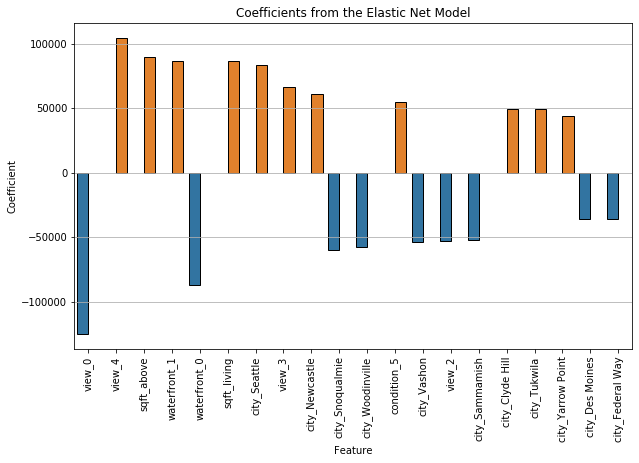

In [1050]:
plt.figure(figsize=(10,6))
sns.barplot(x=np.arange(len(elasticnet_coef)), y=elasticnet_coef['coefficient'], hue=np.sign(elasticnet_coef['coefficient']), edgecolor='k')
plt.gca().legend().remove()
plt.grid(axis='y')
plt.xticks(np.arange(len(elasticnet_coef)), labels=elasticnet_coef['variable'], rotation=90)
plt.ylabel('Coefficient')
plt.xlabel('Feature')
plt.title('Coefficients from the Elastic Net Model')
plt.show()

Plotting the top coefficients for Lasso

In [1051]:
lasso_coef = pd.DataFrame({'variable':columns_list, 'coefficient':lasso_pipe.named_steps['lasso'].coef_})
lasso_coef['abs_coef'] = abs(lasso_coef['coefficient'])
lasso_coef = lasso_coef.sort_values('abs_coef', ascending=False).reset_index(drop=True)
lasso_coef = lasso_coef[:20]

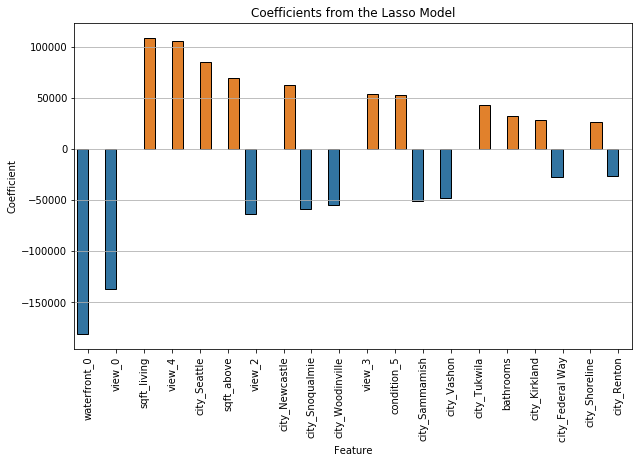

In [1052]:
plt.figure(figsize=(10,6))
sns.barplot(x=np.arange(len(lasso_coef)), y=lasso_coef['coefficient'], hue=np.sign(lasso_coef['coefficient']), edgecolor='k')
plt.gca().legend().remove()
plt.grid(axis='y')
plt.xticks(np.arange(len(lasso_coef)), labels=lasso_coef['variable'], rotation=90)
plt.ylabel('Coefficient')
plt.xlabel('Feature')
plt.title('Coefficients from the Lasso Model')
plt.show()

Plotting the top coefficients for Ridge

In [1053]:
ridge_coef = pd.DataFrame({'variable':columns_list, 'coefficient':ridge_pipe.named_steps['ridge'].coef_})
ridge_coef['abs_coef'] = abs(ridge_coef['coefficient'])
ridge_coef = ridge_coef.sort_values('abs_coef', ascending=False).reset_index(drop=True)
ridge_coef = ridge_coef[:20]

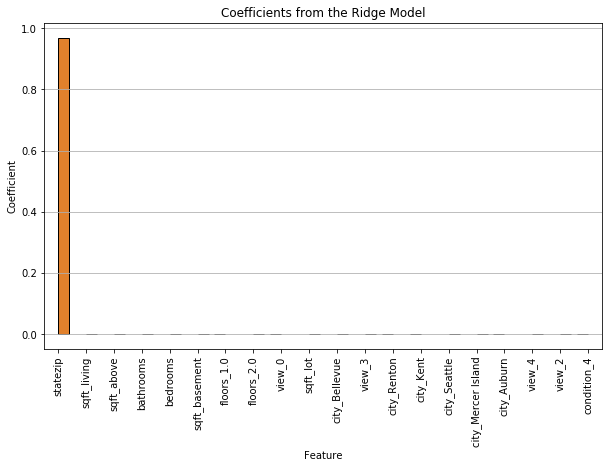

In [1054]:
plt.figure(figsize=(10,6))
sns.barplot(x=np.arange(len(elasticnet_coef)), y=ridge_coef['coefficient'], hue=np.sign(ridge_coef['coefficient']), edgecolor='k')
plt.gca().legend().remove()
plt.grid(axis='y')
plt.xticks(np.arange(len(ridge_coef)), labels=ridge_coef['variable'], rotation=90)
plt.ylabel('Coefficient')
plt.xlabel('Feature')
plt.title('Coefficients from the Ridge Model')
plt.show()

Based on the above plots, we can say that the top 20 coefficients for Elastic Net and Lasso have a high overlap. This is also expected based on the fact that the l1ratio that performed well at different values of alpha for Elastic Net seemed to be 1 indicating more of a Lasso model than a ridge model. Some observations from the coefficients:    
* If a house not on a waterfront (waterfront=0) and if a house does not have a view (view=0) that has a high adverse impact on price
* If the house has a good view it has a high positive impact on price
* Similarly, as the square feet (living) increases the price of the house increases

Note that the coefficients are obtained on standardized data (for continuous variables) - so they indicate the expected increase in price for a 1 standard deviation change in the value

However, for Ridge regression, there was one coefficient that dominated the model (statezip) even with high regularization alpha. This seems to be a problem that needs to be diagnosed further. The model also does not do as well as the Lasso and Elastic Net and hence can be dropped from consideration